In [9]:
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.signal import stft
from mat4py import loadmat
from EEG_analyzer import *
from private_tool import *
from math import log
import pandas as pd
import numpy as np

In [2]:
currDir = workingDirectory()

In [3]:
experimentNum = 3
data = []
for i in range(experimentNum):
    print(i)
    data.append(loadmat(currDir + f'./동작 상상 제어/data/Left-Right Hand ML//s{str(i+1).zfill(2)}.mat'))
data = np.array(data)

0


1
2


In [4]:
# 각 subject에 대한 left, right imagery data
samplingRate = data[0]["eeg"]["srate"]  
imagine_left = np.array([data[i]["eeg"]["imagery_left"] for i in range(len(data))])
for i in range(experimentNum):
    data[i]["eeg"]["imagery_left"] = []
imagine_right = np.array([data[i]["eeg"]["imagery_right"] for i in range(len(data))])
for i in range(experimentNum):
    data[i]["eeg"]["imagery_right"] = []
data = []

In [5]:
data_electrodes = ["FP1", "AF7", "AF3", "F1", "F3", "F5", "F7", "FT7", "FC5", "FC3", "FC1", "C1", "C3", "C5", "T7", "TP7", "CP5", "CP3", "CP", "P1", "P3", "P5", "P7", "P9", "PO7", "PO3", "O1", 
              "lz", "Oz", "POz", "Pz", "CPz", "FPZ", "FP2", "AD8", "AF4", "AFZ", "FZ", "F2", "F4", "F6", "F8", "FT8", "FC6", "FC4", "FC2", "FCz", "Cz", "C2", "C4", "C6", "T8", "TP8", "CP6",
              "CP4", "CP2", "P2", "P4", "P6", "P8", "P10", "PO8", "PO4", "O2"]
print(len(data_electrodes))

64


In [6]:
electrodes = ["FP1", "FP2", "FZ", "F3", "F4", "F7", "F8", "Cz", "C3", "C4", "T7", "T8", "P7", "P8", "Pz", "P3", "P4", "O1", "O2"]
print(electrodes)

['FP1', 'FP2', 'FZ', 'F3', 'F4', 'F7', 'F8', 'Cz', 'C3', 'C4', 'T7', 'T8', 'P7', 'P8', 'Pz', 'P3', 'P4', 'O1', 'O2']


In [7]:
interelectrodes_index = [data_electrodes.index(n) for n in electrodes] # 가지고 있는 DSI-24에 해당하는 채널만 불러오기 위한 인덱스
print(interelectrodes_index)
print(data_electrodes.index("Pz"))

[0, 33, 37, 4, 39, 6, 41, 47, 12, 49, 14, 51, 22, 59, 30, 20, 57, 26, 63]
30


In [8]:
print(imagine_left.shape)
print(imagine_right.shape)
print(interelectrodes_index)

(3, 68, 358400)
(3, 68, 358400)
[0, 33, 37, 4, 39, 6, 41, 47, 12, 49, 14, 51, 22, 59, 30, 20, 57, 26, 63]


In [9]:
# 주어진 EEG 데이터를 피험자 별로 저장한 array임
# 실험 번호 - 채널 번호 - sample index 순으로 저장된 3차원 array
imagine_left_data = np.array([[imagine_left[i][j] for j in interelectrodes_index] for i in range(experimentNum)])
imagine_left = []

In [10]:
imagine_right_data = np.array([[imagine_right[i][j] for j in interelectrodes_index] for i in range(experimentNum)])
imagine_right = []

In [11]:
imagine_left_data = np.array(imagine_left_data)
imagine_right_data = np.array(imagine_right_data)
print(imagine_left_data.shape)
print(imagine_right_data.shape)

(3, 19, 358400)
(3, 19, 358400)


In [12]:
# # ================기준 전극 값 빼는거 안 만듦===============
# referenceElectrode = electrodes.index("Pz")

# imagine_left_data = ([([([imagine_left_data[i][j][k] - imagine_left_data[i][referenceElectrode][k] for k in range(358400)]) for j in range(19)]) for i in range(experimentNum)])
# for i in range(experimentNum):
#     imagine_left_data[i][referenceElectrode].pop()
# imagine_left_data = np.array([np.array([np.array(j) for j in i]) for i in imagine_left_data])

# imagine_right_data = ([([([imagine_right_data[i][j][k] - imagine_right_data[i][referenceElectrode][k] for k in range(358400)]) for j in range(19)]) for i in range(experimentNum)])
# for i in range(experimentNum):
#     imagine_right_data[i][referenceElectrode].pop()
# imagine_right_data = np.array([np.array([np.array(j) for j in i]) for i in imagine_right_data])



In [13]:
sample_rate = samplingRate  # 샘플링 주파수 (Hz)
cutoff_low = 2  # 최저 주파수 (Hz)
cutoff_high = 50  # 최고 주파수 (Hz)

channelNum = len(interelectrodes_index)

# 데이터 필터링
bandpass_filtered_left_data = [np.array([np.array(bandpass_filter(imagine_left_data[i][j], sample_rate, cutoff_low, cutoff_high)) for j in range(channelNum)]) for i in range(experimentNum)]
bandpass_filtered_right_data = [np.array([np.array(bandpass_filter(imagine_right_data[i][j], sample_rate, cutoff_low, cutoff_high)) for j in range(channelNum)]) for i in range(experimentNum)]
imagine_left_data = []
imagine_right_data = []
# bandpass_filtered_left_data = np.array(bandpass_filtered_left_data)
# bandpass_filtered_right_data = np.array(bandpass_filtered_right_data)

In [14]:
print(len(bandpass_filtered_right_data))

3


In [15]:
left_csp_filter = CSP_filter(experimentNum, bandpass_filtered_left_data)
right_csp_filter = CSP_filter(experimentNum, bandpass_filtered_right_data)

(19, 19)
(19, 19)


In [16]:
CSP_passed_left_data = np.array([bandpass_filtered_left_data[i].T@left_csp_filter for i in range(experimentNum)])
CSP_passed_right_data = np.array([bandpass_filtered_right_data[i].T@right_csp_filter for i in range(experimentNum)])

In [17]:
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
# print(CSP_passed_left_data.shape)
# print(CSP_passed_right_data.shape)

In [18]:
m = 3
leftVar = np.array([np.array([np.var(CSP_passed_left_data[i][j]) for j in range(channelNum)]) for i in range(experimentNum)])
rightVar = np.array([np.array([np.var(CSP_passed_right_data[i][j]) for j in range(channelNum)]) for i in range(experimentNum)])

leftVarRatio = np.array([np.array([log(leftVar[i][j-m]/sum(leftVar[i])) for j in range(m*2)]) for i in range(experimentNum)])
rightVarRatio = np.array([np.array([log(rightVar[i][j-m]/sum(rightVar[i])) for j in range(m*2)]) for i in range(experimentNum)])
print(leftVar)

[[6.99052982e+06 2.29272883e+06 4.17832048e+07 6.12749548e+07
  1.12691855e+07 2.79528613e+06 4.12421759e+06 3.19910420e+07
  3.11650398e+07 1.33817025e+07 8.58606388e+06 2.49590225e+07
  7.96068437e+06 4.96638468e+07 2.98853900e+07 3.60716688e+08
  2.84892655e+07 1.00825625e+07 5.90275073e+07]
 [1.32898371e+06 7.99190745e+05 7.91858264e+07 5.60087427e+06
  8.48943385e+06 7.13278522e+06 1.32628944e+06 4.01280790e+07
  4.70658030e+06 3.60285044e+06 2.59117132e+06 5.56885568e+06
  6.23272568e+06 5.55734466e+06 2.82391598e+07 5.07099285e+07
  8.88631668e+06 2.48314439e+06 7.71510535e+06]
 [4.01781237e+06 4.54816193e+06 4.21588587e+07 1.81922506e+07
  1.82798206e+07 1.82686458e+06 1.18238167e+07 1.92361216e+07
  1.61400406e+07 1.60408200e+07 7.30471806e+06 1.35782176e+07
  5.50159655e+06 5.80488546e+06 3.53836218e+07 3.91960904e+07
  2.72116959e+07 3.07451273e+06 1.18986544e+07]]


In [19]:
print(leftVarRatio)

[[-3.31798769 -4.35670762 -2.5895115  -4.72295871 -5.83777232 -2.9350206 ]
 [-3.414963   -4.68994999 -3.55629551 -5.31506112 -5.82363128 -1.22767832]
 [-2.40418924 -4.58468969 -3.2314108  -4.31709855 -4.19311294 -1.96639128]]


In [20]:
leftVarRatioDF = pd.DataFrame(leftVarRatio)
rightVarRatioDF = pd.DataFrame(rightVarRatio)
labelDF = pd.DataFrame([0]*experimentNum + [1]*experimentNum)

In [21]:
VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF], axis=0)
VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:,1:]
VarRatioDF.columns = [f"{m}" for m in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,4,5,target
0,-3.317988,-4.356708,-2.589512,-4.722959,-5.837772,-2.935021,0
1,-3.414963,-4.689950,-3.556296,-5.315061,-5.823631,-1.227678,0
2,-2.404189,-4.584690,-3.231411,-4.317099,-4.193113,-1.966391,0
3,-2.883258,-4.305901,-5.395952,-5.889678,-5.651168,-3.044117,1
4,-3.041422,-4.694849,-3.779428,-6.072482,-5.136676,-1.269051,1
5,-2.219166,-2.537698,-3.966277,-3.149424,-3.468024,-2.869783,1


In [22]:
from sklearn.preprocessing import StandardScaler, RobustScaler
x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5
0,-0.992670,-0.213864,1.357301,0.188767,-0.914289,-0.929204
1,-1.212541,-0.654496,0.229613,-0.405252,-0.898510,1.285462
2,1.079170,-0.515315,0.608569,0.595941,0.920883,0.327246
3,-0.007014,-0.146685,-1.916223,-0.981728,-0.706069,-1.070718
4,-0.365617,-0.660973,-0.030657,-1.165124,-0.131979,1.231796
5,1.498672,2.191334,-0.248603,1.767395,1.729964,-0.844582


In [11]:
PCA = PrincipalComponentAnalysis(n_componunts=5, data=x)
principalDf = PCA.principalDf

NameError: name 'PrincipalComponentAnalysis' is not defined

In [6]:
PCA.explained_variance_ratio_

AttributeError: type object 'PCA' has no attribute 'explained_variance_ratio_'

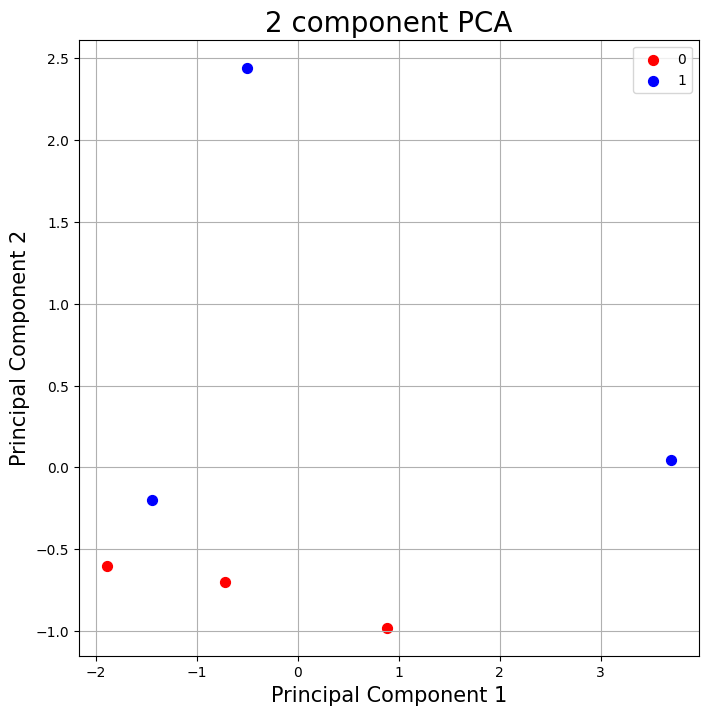

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = VarRatioDF['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [26]:
principalDf = principalDf.to_numpy()
principalDf

array([[-0.724503  , -0.70209539,  1.8801143 ,  0.19713917,  0.1297727 ],
       [-1.89164701, -0.605354  , -0.21870381, -0.68848228, -0.32967046],
       [ 0.88382118, -0.97969143, -0.72883379,  0.89855937, -0.17673172],
       [-0.51001131,  2.44191897,  0.10613494,  0.2471285 , -0.08259839],
       [-1.45130122, -0.20003858, -1.06577576, -0.11452992,  0.4104515 ],
       [ 3.69364136,  0.04526043,  0.02706412, -0.53981484,  0.04877638]])

In [31]:
principalDf_lda = lda(principalDf, y, 1)

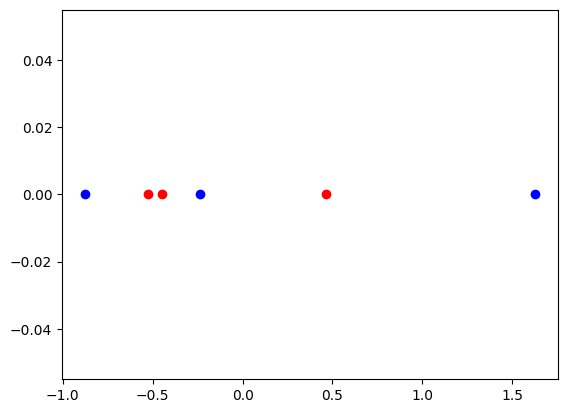

In [32]:
colors = ["r", "b"]
labels = ["left", "right"]
for i in range(y.shape[0]):
    plt.scatter(principalDf_lda[i], 0, c=colors[y[i]])